## 파이토치 기초(7) - GAN

* day 1 - 텐서와 Autograd : https://dacon.io/codeshare/4478
* day 2 - 신경망모델 구현하기 : https://dacon.io/codeshare/4495
* day 3 - DNN : https://dacon.io/codeshare/4532
* day 4 - CNN : https://dacon.io/codeshare/4537
* day 5 - AutoEncoder 오토 인코더 : https://dacon.io/codeshare/4551

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 하이퍼파라미터
EPOCHS = 500
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [3]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

In [4]:
# 생성자 (Generator)
G = nn.Sequential(
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Tanh())

In [5]:
# 판별자 (Discriminator)
D = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1),
        nn.Sigmoid())

In [6]:
# 모델의 가중치를 지정한 장치로 보내기
D = D.to(DEVICE)
G = G.to(DEVICE)

# 이진 크로스 엔트로피 (Binary cross entropy) 오차 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)

In [7]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)
        
        # 판별자가 진짜 이미지를 진짜로 인식하는 오차를 예산
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # 무작위 텐서로 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
        fake_images = G(z)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차를 계산
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake

        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차를 계산
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    # 학습 진행 알아보기
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
          .format(epoch, EPOCHS, d_loss.item(), g_loss.item(), 
                  real_score.mean().item(), fake_score.mean().item()))

Epoch [0/500], d_loss: 0.0291, g_loss: 5.5857, D(x): 0.99, D(G(z)): 0.02
Epoch [1/500], d_loss: 0.0169, g_loss: 5.9794, D(x): 0.99, D(G(z)): 0.01
Epoch [2/500], d_loss: 0.0151, g_loss: 7.4223, D(x): 1.00, D(G(z)): 0.01
Epoch [3/500], d_loss: 0.0155, g_loss: 9.0655, D(x): 0.99, D(G(z)): 0.00
Epoch [4/500], d_loss: 0.2175, g_loss: 7.0592, D(x): 0.94, D(G(z)): 0.04
Epoch [5/500], d_loss: 0.0646, g_loss: 4.2504, D(x): 0.98, D(G(z)): 0.03
Epoch [6/500], d_loss: 0.1090, g_loss: 3.7022, D(x): 0.96, D(G(z)): 0.05
Epoch [7/500], d_loss: 0.3756, g_loss: 4.8129, D(x): 0.93, D(G(z)): 0.05
Epoch [8/500], d_loss: 0.2150, g_loss: 3.7147, D(x): 0.93, D(G(z)): 0.03
Epoch [9/500], d_loss: 0.3663, g_loss: 3.9995, D(x): 0.93, D(G(z)): 0.12
Epoch [10/500], d_loss: 0.1750, g_loss: 4.1805, D(x): 0.94, D(G(z)): 0.05
Epoch [11/500], d_loss: 0.1852, g_loss: 4.7130, D(x): 0.95, D(G(z)): 0.07
Epoch [12/500], d_loss: 0.4667, g_loss: 4.2570, D(x): 0.86, D(G(z)): 0.06
Epoch [13/500], d_loss: 0.1302, g_loss: 4.1206, 

Epoch [111/500], d_loss: 1.1386, g_loss: 1.5184, D(x): 0.72, D(G(z)): 0.38
Epoch [112/500], d_loss: 0.7923, g_loss: 1.6079, D(x): 0.77, D(G(z)): 0.29
Epoch [113/500], d_loss: 0.9788, g_loss: 2.0717, D(x): 0.59, D(G(z)): 0.15
Epoch [114/500], d_loss: 0.7501, g_loss: 2.1744, D(x): 0.71, D(G(z)): 0.22
Epoch [115/500], d_loss: 1.0596, g_loss: 1.4863, D(x): 0.69, D(G(z)): 0.35
Epoch [116/500], d_loss: 0.9609, g_loss: 1.7032, D(x): 0.67, D(G(z)): 0.28
Epoch [117/500], d_loss: 0.5743, g_loss: 2.3436, D(x): 0.80, D(G(z)): 0.21
Epoch [118/500], d_loss: 0.9758, g_loss: 1.8003, D(x): 0.68, D(G(z)): 0.30
Epoch [119/500], d_loss: 0.5771, g_loss: 2.3403, D(x): 0.80, D(G(z)): 0.21
Epoch [120/500], d_loss: 1.1258, g_loss: 1.8912, D(x): 0.69, D(G(z)): 0.35
Epoch [121/500], d_loss: 0.8273, g_loss: 1.7771, D(x): 0.78, D(G(z)): 0.29
Epoch [122/500], d_loss: 1.0972, g_loss: 1.4908, D(x): 0.58, D(G(z)): 0.23
Epoch [123/500], d_loss: 1.1241, g_loss: 2.2446, D(x): 0.64, D(G(z)): 0.21
Epoch [124/500], d_loss: 

Epoch [221/500], d_loss: 1.0774, g_loss: 1.3954, D(x): 0.69, D(G(z)): 0.39
Epoch [222/500], d_loss: 0.8096, g_loss: 1.6237, D(x): 0.68, D(G(z)): 0.26
Epoch [223/500], d_loss: 1.1484, g_loss: 1.5100, D(x): 0.64, D(G(z)): 0.34
Epoch [224/500], d_loss: 0.8219, g_loss: 1.9419, D(x): 0.69, D(G(z)): 0.24
Epoch [225/500], d_loss: 0.7890, g_loss: 1.5136, D(x): 0.69, D(G(z)): 0.27
Epoch [226/500], d_loss: 1.2398, g_loss: 1.1170, D(x): 0.62, D(G(z)): 0.41
Epoch [227/500], d_loss: 0.6829, g_loss: 1.9209, D(x): 0.78, D(G(z)): 0.26
Epoch [228/500], d_loss: 0.8680, g_loss: 1.3463, D(x): 0.71, D(G(z)): 0.33
Epoch [229/500], d_loss: 1.2372, g_loss: 1.1249, D(x): 0.64, D(G(z)): 0.42
Epoch [230/500], d_loss: 1.3085, g_loss: 1.1614, D(x): 0.61, D(G(z)): 0.39
Epoch [231/500], d_loss: 1.1279, g_loss: 1.3101, D(x): 0.71, D(G(z)): 0.41
Epoch [232/500], d_loss: 1.2016, g_loss: 1.2637, D(x): 0.60, D(G(z)): 0.35
Epoch [233/500], d_loss: 0.9375, g_loss: 1.3247, D(x): 0.69, D(G(z)): 0.35
Epoch [234/500], d_loss: 

Epoch [331/500], d_loss: 0.9753, g_loss: 1.4312, D(x): 0.65, D(G(z)): 0.31
Epoch [332/500], d_loss: 0.6756, g_loss: 1.9111, D(x): 0.72, D(G(z)): 0.22
Epoch [333/500], d_loss: 0.9206, g_loss: 1.5420, D(x): 0.71, D(G(z)): 0.32
Epoch [334/500], d_loss: 0.8741, g_loss: 1.4118, D(x): 0.70, D(G(z)): 0.31
Epoch [335/500], d_loss: 0.9662, g_loss: 1.6550, D(x): 0.66, D(G(z)): 0.30
Epoch [336/500], d_loss: 1.3064, g_loss: 1.1937, D(x): 0.62, D(G(z)): 0.43
Epoch [337/500], d_loss: 1.2119, g_loss: 1.3534, D(x): 0.54, D(G(z)): 0.31
Epoch [338/500], d_loss: 0.6963, g_loss: 1.7070, D(x): 0.76, D(G(z)): 0.27
Epoch [339/500], d_loss: 0.9125, g_loss: 1.7138, D(x): 0.68, D(G(z)): 0.28
Epoch [340/500], d_loss: 1.3991, g_loss: 1.2992, D(x): 0.62, D(G(z)): 0.41
Epoch [341/500], d_loss: 0.9180, g_loss: 1.4664, D(x): 0.71, D(G(z)): 0.33
Epoch [342/500], d_loss: 0.7826, g_loss: 1.8106, D(x): 0.70, D(G(z)): 0.25
Epoch [343/500], d_loss: 1.0237, g_loss: 1.3610, D(x): 0.67, D(G(z)): 0.35
Epoch [344/500], d_loss: 

Epoch [441/500], d_loss: 0.7637, g_loss: 1.5552, D(x): 0.74, D(G(z)): 0.29
Epoch [442/500], d_loss: 0.9326, g_loss: 1.4603, D(x): 0.72, D(G(z)): 0.33
Epoch [443/500], d_loss: 0.9140, g_loss: 1.8098, D(x): 0.65, D(G(z)): 0.24
Epoch [444/500], d_loss: 1.0472, g_loss: 1.5180, D(x): 0.67, D(G(z)): 0.34
Epoch [445/500], d_loss: 0.8749, g_loss: 1.5041, D(x): 0.73, D(G(z)): 0.32
Epoch [446/500], d_loss: 0.9658, g_loss: 1.5866, D(x): 0.65, D(G(z)): 0.28
Epoch [447/500], d_loss: 0.9458, g_loss: 1.4151, D(x): 0.73, D(G(z)): 0.36
Epoch [448/500], d_loss: 0.9894, g_loss: 1.3058, D(x): 0.70, D(G(z)): 0.36
Epoch [449/500], d_loss: 0.9820, g_loss: 1.5930, D(x): 0.68, D(G(z)): 0.31
Epoch [450/500], d_loss: 1.0078, g_loss: 1.5425, D(x): 0.65, D(G(z)): 0.32
Epoch [451/500], d_loss: 0.7063, g_loss: 1.9950, D(x): 0.71, D(G(z)): 0.21
Epoch [452/500], d_loss: 0.9708, g_loss: 1.4926, D(x): 0.65, D(G(z)): 0.29
Epoch [453/500], d_loss: 0.8331, g_loss: 1.5441, D(x): 0.70, D(G(z)): 0.27
Epoch [454/500], d_loss: 

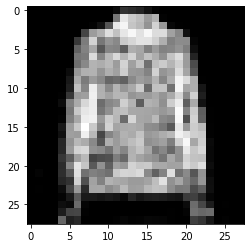

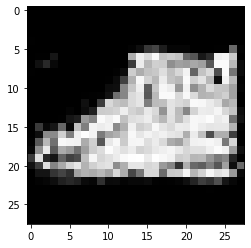

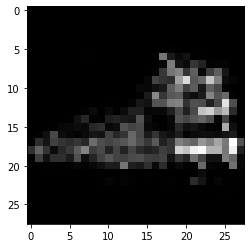

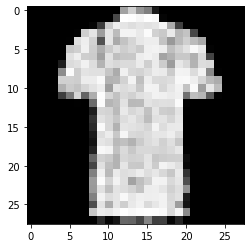

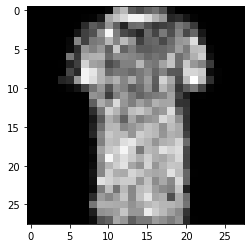

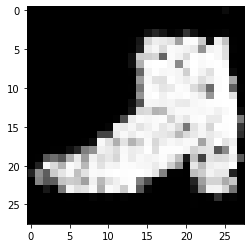

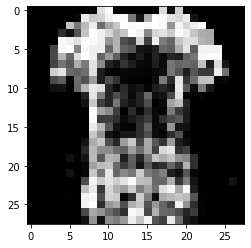

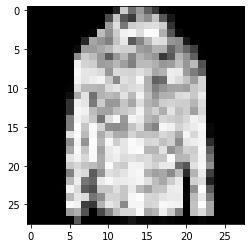

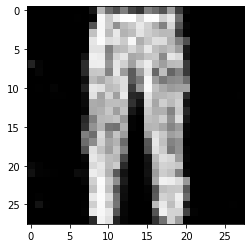

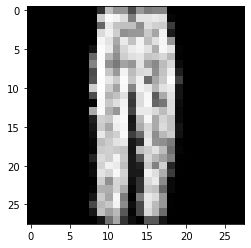

In [8]:
z = torch.randn(BATCH_SIZE, 64).to(DEVICE)
fake_images = G(z)
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')
    plt.show()

In [9]:
# 하이퍼파라미터
EPOCHS = 300
BATCH_SIZE = 100
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [10]:
# Fashion MNIST 데이터셋
trainset = datasets.FashionMNIST(
    './.data',
    train=True,
    download=True,
    transform=transforms.Compose([
       transforms.ToTensor(),
       transforms.Normalize((0.5,), (0.5,))
    ])
)
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True
)

In [11]:
# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [12]:
# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.embed = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        c = self.embed(labels)
        x = torch.cat([x, c], 1)
        return self.model(x)

In [13]:
# 모델 인스턴스를 만들고 모델의 가중치를 지정한 장치로 보내기
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)

# 이진 교차 엔트로피 함수와
# 생성자와 판별자를 최적화할 Adam 모듈
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr =0.0002)
g_optimizer = optim.Adam(G.parameters(), lr =0.0002)

In [ ]:
total_step = len(train_loader)
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(BATCH_SIZE, -1).to(DEVICE)
        
        # '진짜'와 '가짜' 레이블 생성
        real_labels = torch.ones(BATCH_SIZE, 1).to(DEVICE)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(DEVICE)

        # 판별자가 진짜 이미지를 진짜로 인식하는 오차 계산 (데이터셋 레이블 입력)
        labels = labels.to(DEVICE)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
    
        # 무작위 텐서와 무작위 레이블을 생성자에 입력해 가짜 이미지 생성
        z = torch.randn(BATCH_SIZE, 100).to(DEVICE)
        g_label = torch.randint(0, 10, (BATCH_SIZE,)).to(DEVICE)
        fake_images = G(z, g_label)
        
        # 판별자가 가짜 이미지를 가짜로 인식하는 오차 계산
        outputs = D(fake_images, g_label)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # 진짜와 가짜 이미지를 갖고 낸 오차를 더해서 판별자의 오차 계산
        d_loss = d_loss_real + d_loss_fake
        
        # 역전파 알고리즘으로 판별자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # 생성자가 판별자를 속였는지에 대한 오차 계산(무작위 레이블 입력)
        fake_images = G(z, g_label)
        outputs = D(fake_images, g_label)
        g_loss = criterion(outputs, real_labels)

        # 역전파 알고리즘으로 생성자 모델의 학습을 진행
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
    print('이폭 [{}/{}] d_loss:{:.4f} g_loss: {:.4f} D(x):{:.2f} D(G(z)):{:.2f}'
          .format(epoch,
                  EPOCHS,
                  d_loss.item(),
                  g_loss.item(),
                  real_score.mean().item(),
                  fake_score.mean().item()))

이폭 [0/300] d_loss:0.1324 g_loss: 5.6149 D(x):0.95 D(G(z)):0.05
이폭 [1/300] d_loss:0.4619 g_loss: 4.5284 D(x):0.85 D(G(z)):0.15
이폭 [2/300] d_loss:0.5108 g_loss: 4.8493 D(x):0.83 D(G(z)):0.07
이폭 [3/300] d_loss:0.4944 g_loss: 3.3446 D(x):0.87 D(G(z)):0.16
이폭 [4/300] d_loss:0.5522 g_loss: 2.6130 D(x):0.87 D(G(z)):0.24
이폭 [5/300] d_loss:0.5702 g_loss: 1.9010 D(x):0.85 D(G(z)):0.25
이폭 [6/300] d_loss:0.7290 g_loss: 2.1103 D(x):0.82 D(G(z)):0.28
이폭 [7/300] d_loss:0.9881 g_loss: 1.9109 D(x):0.73 D(G(z)):0.31
이폭 [8/300] d_loss:0.7552 g_loss: 1.9287 D(x):0.76 D(G(z)):0.23
이폭 [9/300] d_loss:0.7583 g_loss: 1.7691 D(x):0.76 D(G(z)):0.26
이폭 [10/300] d_loss:0.9038 g_loss: 1.5192 D(x):0.72 D(G(z)):0.30
이폭 [11/300] d_loss:0.9332 g_loss: 1.4990 D(x):0.73 D(G(z)):0.35
이폭 [12/300] d_loss:0.7696 g_loss: 1.7951 D(x):0.70 D(G(z)):0.21
이폭 [13/300] d_loss:0.9357 g_loss: 1.4554 D(x):0.69 D(G(z)):0.30
이폭 [14/300] d_loss:1.3092 g_loss: 1.3903 D(x):0.62 D(G(z)):0.37
이폭 [15/300] d_loss:0.8974 g_loss: 1.5065 D(x):0.72

In [ ]:
# 만들고 싶은 아이템 생성하고 시각화하기
item_number = 9 # 아이템 번호
z = torch.randn(1, 100).to(DEVICE) # 배치 크기 1
g_label = torch.full((1,), item_number, dtype=torch.long).to(DEVICE)
sample_images = G(z, g_label)

sample_images_img = np.reshape(sample_images.data.cpu().numpy()
                               [0],(28, 28))
plt.imshow(sample_images_img, cmap = 'gray')
plt.show()